# Learn Recurrence

Works with `neg_voja_lr=5e-6` and `intercept=0.15`. Breaks on `neg_voja_lr=8e-6` and `intercept=0.1`

In [1]:
from collections import namedtuple, OrderedDict
import os

import h5py
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import nengo
from nengo.utils.ensemble import tuning_curves
import nengolib
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import (numpy_bytes_to_str, norm_spa_vecs, BasicVecFeed)
from nengo_learn_assoc_mem.paths import data_path

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Compare loaded variables

In [42]:
neg_voja_lr = 8e-6
intercept = 0.15
n_repeats = 4

load_path = os.path.join(data_path, "neg_voja_enc", f"neg_voja_enc_{n_repeats}_{intercept}_{neg_voja_lr}.h5")

with h5py.File(load_path, "r") as fi:

    new_v_vecs = list(fi['vocab_vectors'])
    new_v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    new_seed = fi['encoders'].attrs['seed']

In [45]:
neg_voja_lr = 5e-6
intercept = 0.1
n_repeats = 4

load_path = os.path.join(data_path, "neg_voja_enc", f"neg_voja_enc_{n_repeats}_{intercept}_{neg_voja_lr}.h5")

with h5py.File(load_path, "r") as fi:

    orig_v_vecs = list(fi['vocab_vectors'])
    orig_v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    orig_seed = fi['encoders'].attrs['seed']

In [46]:
for new, orig in zip(new_v_vecs, orig_v_vecs):
    assert np.sum(np.abs(new-orig)) == 0.0

for new, orig in zip(new_v_strs, orig_v_strs):
    print(new, orig)

assert new_seed == orig_seed

F1_10 F1_15
F1_23 F1_12
F2_15 F1_6
F1_16 F2_5
F1_21 F1_21
F1_29 F1_8
F2_6 F2_8
F1_3 F1_24
F1_27 F1_11
F2_8 F1_28
F1_14 F2_13
F2_9 F2_15
F2_11 F1_13
F1_17 F1_2
F1_26 F1_29
F2_4 F2_6
F1_22 F2_7
F1_6 F2_14
F2_10 F2_0
F2_0 F1_16
F2_7 F1_5
F1_20 F1_17
F1_19 F1_10
F2_1 F1_23
F1_12 F1_30
F1_8 F1_4
F1_4 F1_0
F2_14 F1_14
F1_11 F1_19
F1_24 F2_1
F2_2 F1_7
F1_15 F2_12
F1_28 F1_3
F1_2 F1_22
F1_30 F2_10
F1_1 F2_2
F2_5 F1_27
F1_9 F1_1
F1_25 F1_26
F1_5 F1_18
F2_13 F2_4
F1_13 F1_31
F1_18 F1_25
F2_12 F2_3
F2_3 F2_9
F1_0 F1_20
F1_7 F1_9
F1_31 F2_11


## Setup

In [2]:
neg_voja_lr = 8e-6
intercept = 0.15
n_repeats = 4

load_path = os.path.join(data_path, "neg_voja_enc", f"neg_voja_enc_{n_repeats}_{intercept}_{neg_voja_lr}.h5")

In [3]:
with h5py.File(load_path, "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']

    n_neurons = fi['encoders'].shape[1]
    seed = fi['encoders'].attrs['seed']

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 'response', 't_range', 'vocab_strings', 'vocab_vectors']


In [4]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [5]:
t_pause = 0.5
t_present = 0.3

t_each = t_pause + t_present
td_each = int(t_each/dt)
td_pause = int(t_pause/dt)

In [6]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [7]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

In [8]:
def meg_eval(fin_enc: np.ndarray, cepts: np.ndarray):
    feed_vecs = fan1_pair_vecs + fan2_pair_vecs + foil1_pair_vecs + foil2_pair_vecs
    
    feed = BasicVecFeed(feed_vecs, feed_vecs, t_present, dimensions, len(feed_vecs), t_pause)

    with nengolib.Network(seed=seed) as learned_model:
        in_nd = nengo.Node(feed.feed)
        pause = nengo.Node(lambda t: feed.paused)
        meg_node = nengo.Node(lambda t, x: np.sum(x), size_in=n_neurons, size_out=1)

        ens = nengo.Ensemble(n_neurons, dimensions,
                             encoders=fin_enc.copy(), intercepts=cepts, seed=seed)

        nengo.Connection(in_nd, ens, synapse=None)
        nengo.Connection(pause, ens.neurons, transform=-10*np.ones((n_neurons, 1)), synapse=None)
        nengo.Connection(ens.neurons, meg_node, synapse=None)

        p_in = nengo.Probe(in_nd)
        p_meg = nengo.Probe(meg_node, synapse=0.05)

    with nengo.Simulator(learned_model) as learned_sim:
        learned_sim.run(len(feed_vecs)*t_each + t_pause)
        
    return learned_sim.trange(), learned_sim.data[p_meg].flatten()

In [9]:
def plt_meg(t_range: np.ndarray, meg_res: np.ndarray) -> pd.DataFrame:
    df_list = []

    for key, obj in slc_stim_vecs.items():
        act = meg_res[obj.slc]
        resp = [obj.fan_num] * len(act)
        targ = [obj.targ] * len(act)
        df_list.append(pd.DataFrame({"act": act, "resp": resp, "targ": targ}))

    act_df = pd.concat(df_list)
    
    plt.figure()
    ax = sns.barplot(x="resp", y="act", hue="targ", data=act_df)

    ax.set_title("Difference between FAN1 and FAN2 firing rates")
    ax.set_ylabel("Mean Firing Rate")
    ax.set_xlabel("FAN type")

    ax.legend_.set_title("Target vs. Foil")
    ax.legend_.set_bbox_to_anchor((1, 0.8))
    new_labels = ("Foil", "Target")
    for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)
    
    plt.figure(figsize=(12, 3))
    plt.plot(t_range[fan1_slc], meg_res[fan1_slc], linestyle=":")
    plt.plot(t_range[fan2_slc], meg_res[fan2_slc], linestyle=":")
    
    plt.figure(figsize=(12, 3))
    plt.plot(t_range[foil1_slc], meg_res[foil1_slc], linestyle=":")
    plt.plot(t_range[foil2_slc], meg_res[foil2_slc], linestyle=":")
    
    return act_df

# Evaluate

In [10]:
neg_voja_lr = 8e-6 # the range of valid learning rates is (1e-5, 9e-6). WHAT?
intercept = 0.15
n_repeats = 4

load_path = os.path.join(data_path, "neg_voja_enc", f"neg_voja_enc_{n_repeats}_{intercept}_{neg_voja_lr}.h5")

In [11]:
with h5py.File(load_path, "r") as fi:
    
    enc = np.array(fi['encoders'])[-1]
    intercepts = [fi['encoders'].attrs['intercept']] * n_neurons

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc.set('progress', 'progress_bar', 'nengo.utils.progress.TerminalProgressBar')`.

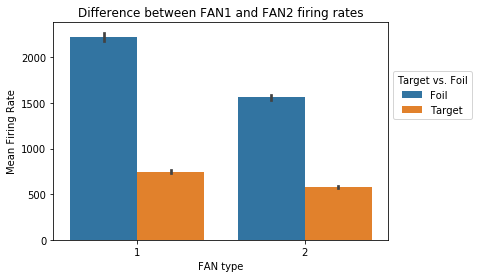

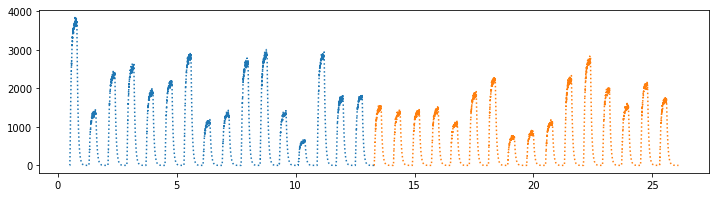

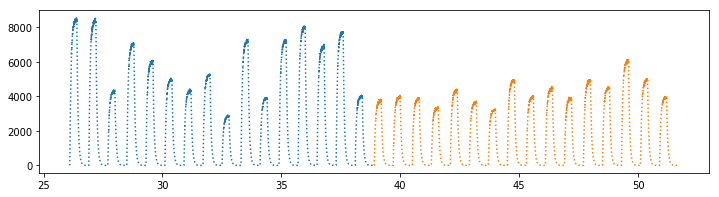

In [12]:
t_range, pos_comb_meg = meg_eval(enc, intercepts)

df = plt_meg(t_range, pos_comb_meg)

In [13]:
fan1_resp = pos_comb_meg[fan1_slc].reshape((-1, td_each))
fan2_resp = pos_comb_meg[fan2_slc].reshape((-1, td_each))
foil1_resp = pos_comb_meg[foil1_slc].reshape((-1, td_each))
foil2_resp = pos_comb_meg[foil2_slc].reshape((-1, td_each))

/usr/local/lib/python3.6/dist-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


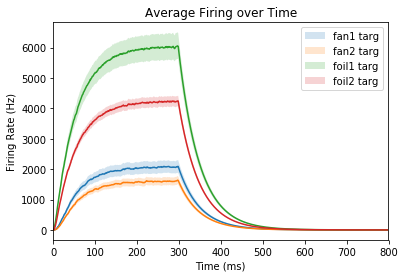

In [14]:
sns.tsplot(fan1_resp, color="C0")
sns.tsplot(fan2_resp, color="C1")
sns.tsplot(foil1_resp, color="C2")
sns.tsplot(foil2_resp, color="C3")

plt.title("Average Firing over Time")
plt.legend(["fan1 targ", "fan2 targ", "foil1 targ", "foil2 targ"], facecolor=None)
plt.ylabel("Firing Rate (Hz)")
plt.xlabel("Time (ms)");